# Classificació de l'idioma d'una paraula
Autors:
- Jonathan Salisbury Vega
- Julià Wallis Medina

Aquesta pràctica consisteix en la classificació de l'idioma d'una paraula emprant SVMs. Per a això, s'ha creat un dataset de paraules en diferents idiomes, i s'han extret diferentes característiques de les paraules. Després s'ha entrenat un model de classificació per tal de poder classificar les paraules en els seus idiomes corresponents.

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read Preprocessed Data

In [14]:
df = pd.read_csv('data/final.csv', index_col=0)
df.head()

,word,lang,len,vow,num_words,apos,hyph,rares,acc,accl,...,en_freq,es_freq,ca_freq,it_freq,fr_freq,pt_freq,de_freq,sv_freq,pl_freq,ru_freq
0,as,1,2,1,0,0,0,0,0,0,...,6.77,4.66,4.22,4.26,5.79,6.73,4.57,4.66,4.51,3.89
1,his,1,3,1,0,0,0,0,0,0,...,6.51,3.63,3.12,3.67,3.70,3.94,3.93,3.89,3.82,3.62
2,that,1,4,1,0,0,0,0,0,0,...,7.01,4.12,3.67,4.24,4.12,4.38,4.56,4.50,4.40,3.98
3,he,1,2,1,0,0,0,0,0,0,...,6.69,5.77,5.87,4.00,4.02,4.01,4.36,4.32,4.39,3.74
4,was,1,3,1,0,0,0,1,0,0,...,6.82,3.84,3.78,3.94,3.83,3.99,6.49,4.01,5.57,3.76


In [15]:
# Check feature correlations with language
df.corr(numeric_only=True).round(2)['lang'].sort_values(ascending=False)

lang       1.00
rus        0.37
sue        0.22
suf_rus    0.19
pre_rus    0.16
           ... 
es_freq   -0.32
fr_freq   -0.34
ca_freq   -0.38
en_freq   -0.41
de_freq   -0.55
Name: lang, Length: 64, dtype: float64

### Data preparation for models

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
# Separate features from target
X = df.drop(['word', 'lang'], axis=1)
y = df['lang']

In [18]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=43)

In [19]:
# Scale Data: https://towardsdatascience.com/feature-scaling-and-normalisation-in-a-nutshell-5319af86f89b
scaler = StandardScaler() # try different scalers
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [20]:
# Dimensionality Reduction: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca = PCA(n_components=0.99, random_state=43) # try different n_components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)
pca.n_components_

53

### Models

In [ ]:
from sklearn import svm

In [ ]:
# Create common Models with different Kernels
models = [
    svm.SVC(kernel='linear', probability=True),  # linear kernel
    svm.SVC(kernel='poly', probability=True),  # polynomial kernel with degree 3
    svm.SVC(kernel='rbf', probability=True),  # RBF kernel with gamma = 0.1
    svm.SVC(kernel='sigmoid', probability=True)
]

# Train models
for model in models:
    model.fit(X_train_pca, y_train)

### Metrics

In [ ]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Accuracy

In [ ]:
for i, model in enumerate(models):
    score = model.score(X_test_pca, y_test)
    print(f'Model {i+1} accuracy: {score * 100}%')

Model 1 accuracy: 82.08502024291498%
Model 2 accuracy: 79.8582995951417%
Model 3 accuracy: 81.37651821862349%
Model 4 accuracy: 76.61943319838058%


Top 3 Accuracy

In [ ]:
for i, model in enumerate(models):
    prediction = model.predict_proba(X_test_pca)
    print(f'Top 3 accuracy model {i+1}: {top_k_accuracy_score(y_test, prediction, k=3)*100}%')

Top 3 accuracy model 1: 96.76113360323887%
Top 3 accuracy model 2: 96.25506072874494%
Top 3 accuracy model 3: 96.5587044534413%
Top 3 accuracy model 4: 95.04048582995951%


Classification Reports

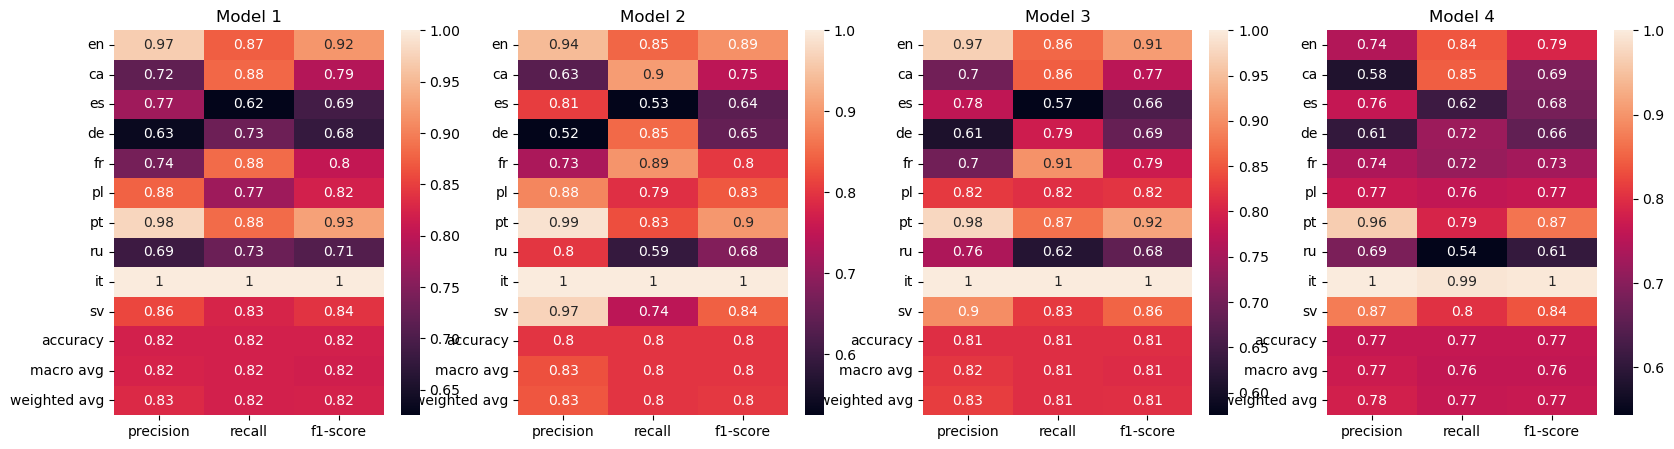

In [ ]:
# Generate classification reports for the models
langs = ['en', 'de', 'ca', 'es', 'fr', 'it', 'pl', 'pt', 'ru','sv']
fig, ax = plt.subplots(1, len(models), figsize=(20, 5))
for i, model in enumerate(models):
    clf_report = classification_report(y_test, model.predict(X_test_pca), zero_division=0, target_names=langs, output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax[i])
    ax[i].set_title(f'Model {i+1}')
plt.show()

Confusion Matrices

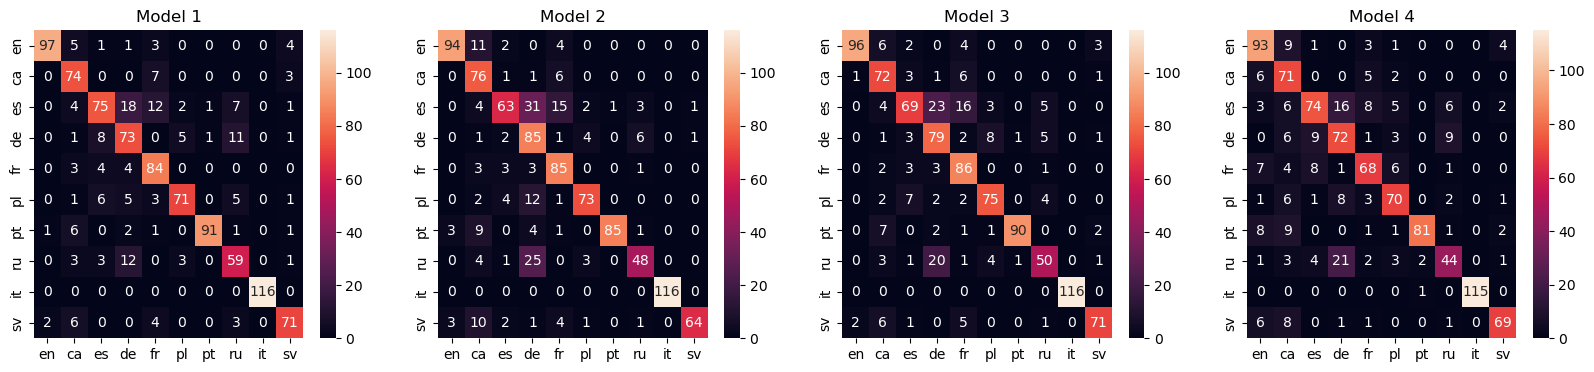

In [ ]:
# Generate confusion matrices for the models and plot them as heatmaps try to make them look pretty,you can use seaborn for this
fig, ax = plt.subplots(1, len(models), figsize=(20, 4))
for i, model in enumerate(models):
    cm = confusion_matrix(y_test, model.predict(X_test_pca))
    sns.heatmap(cm, annot=True, ax=ax[i], fmt='d', xticklabels=langs, yticklabels=langs)
    ax[i].set_title(f'Model {i+1}')
plt.show()


### Grid Search
Lets try to find the best hiperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Let's preform a grid search on the model1 (SVM) to find the best parameters

# parameters = {'C': [0.1, 1, 5, 10], 'gamma': ["scale", "auto", 1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf'], "decision_function_shape": ["ovo", "ovr"]} # AÑADIR SIGMOID???

# grid = GridSearchCV(svm.SVC(), parameters, refit=True, verbose=3)
# grid.fit(X_train_pca, y_train)

# print(grid.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=0.841 total time=   0.1s
[CV 2/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=0.834 total time=   0.1s
[CV 3/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=0.839 total time=   0.1s
[CV 4/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=0.817 total time=   0.1s
[CV 5/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=linear;, score=0.832 total time=   0.1s
[CV 1/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.813 total time=   0.8s
[CV 2/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.813 total time=   0.8s
[CV 3/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.798 total time=   0.9s
[CV 4/5] END C=0.1, decision_function_shape=ovo, gamma=scale, kernel=rbf;, 

Create new Model with the best hyperparameters

Top 3 accuracy model: 95.24%
Accuracy:  81.78 Precision:  86.08 F1-score:  81.86


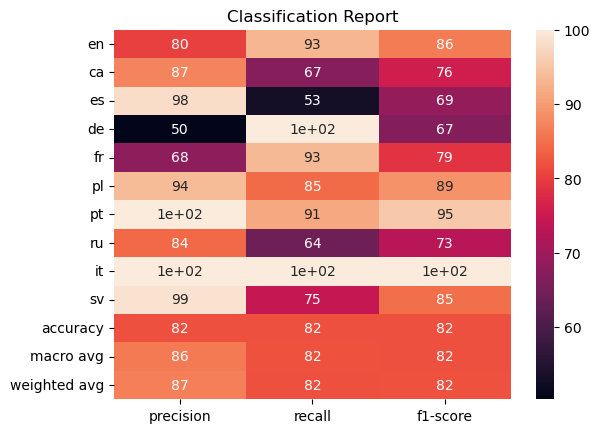

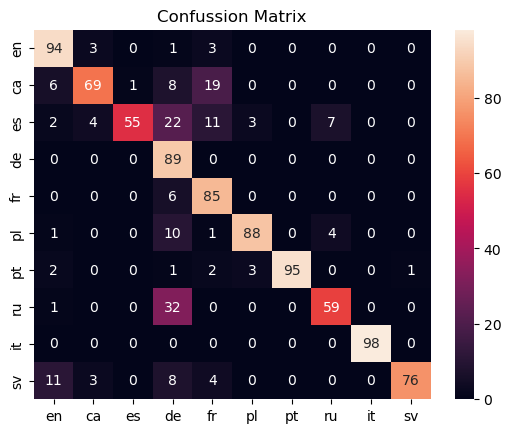

In [ ]:
# Create and train model

model = svm.SVC(C=0.1, kernel='linear', gamma="scale", decision_function_shape="ovo", probability=True)
model.fit(X_train_pca, y_train)
# model = grid.best_estimator_

# Top 3
prediction = model.predict_proba(X_val_pca)
print(f'Top 3 accuracy model: {round(top_k_accuracy_score(y_val, prediction, k=3)*100,2)}%')

# Classification Report
clf_report = classification_report(y_val, model.predict(X_val_pca), zero_division=0, target_names=langs, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True).set(title="Classification Report")
print("Accuracy: ", round(clf_report['accuracy']*100, 2), "Precision: ", round(clf_report['macro avg']['precision']*100,2), "F1-score: ", round(clf_report['macro avg']['f1-score']*100,2))
plt.show()

# Confussion Matrix
cm = confusion_matrix(y_val, model.predict(X_val_pca))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=langs, yticklabels=langs).set(title="Confussion Matrix")
plt.show()


In [ ]:
import numpy as np

In [ ]:
# Separate features from target
df_phrase = pd.read_csv('data/phrase/1.csv', index_col=0)
X_phrase = df_phrase.drop(['word', 'lang'], axis=1)
y_phrase = df_phrase['lang']

X_test_phrase = scaler.transform(X_phrase)
X_test_phrase_pca = pca.transform(X_test_phrase)

prediction = model.predict_proba(X_test_phrase_pca)
# get max index in prediction and print lang
for elem in prediction:
    print(langs[np.argmax(elem)])

fr
de
de
ru
fr
de
de
sv
es
fr
es


c:\Users\walli\miniconda3\envs\pyAA\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
